# Setup

In [86]:
import os
import sys
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
from x_perceiver.train import train_loop
import einops
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

if "x-perceiver" not in os.listdir(): 
    os.chdir("/Users/konsti/Documents/repos/phd/x-perceiver/")
    
%reload_ext autoreload
%autoreload 2

## Simple perceiver vision model

In [44]:
from torch.utils.data import DataLoader
from typing import *

CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
SEED = 42
BATCH_SIZE=4

def load_cifar(batch_size: int, pin_memory: bool=False, num_workers:int=4) -> Tuple[DataLoader]: 
    """
    Loads and transforms cifar dataset
    """
    cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    cifar_train = torchvision.datasets.CIFAR10(root='./data/other', train=True,
                                            download=True, transform=cifar_transform)
    cifar_trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers, pin_memory=True)

    cifar_test = torchvision.datasets.CIFAR10(root='./data/other', train=False,
                                           download=True, transform=cifar_transform)
    cifar_testloader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers, pin_memory=True)
    return cifar_trainloader, cifar_testloader

# load cifar_train
cifar_trainloader, cifar_testloader = load_cifar(batch_size=4, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


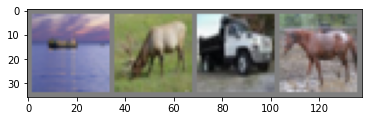

ship  deer  truck horse


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cifar_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))

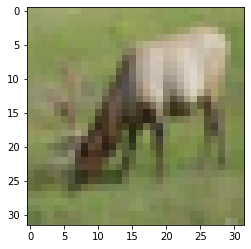

In [8]:
from einops import rearrange, reduce, repeat

img = images[1]
imshow(img)
# add axis
def preprocess_cifar(img) -> torch.Tensor: 
    """
    Reshapes torch tensors from CIFAR format (c h w) to 
    required format for Perceiver: b h w c
    Note that if batch_size=None, the standard b will be set to one, 
    such that the format is always bhwc
    If batch of images is passed in, the size of the batch is preserved
    """
    
    # introduce relevant batch dim
    if len(list(img.size())) == 3: 
        # introduce batch dim if not given
        img = repeat(img, 'c h w -> b c h w', b=1)
    
    # rearrange for perceiver (bhwc)
    img_new = rearrange(img, 'b c h w -> b h w c')

    return img_new

img_new = preprocess_cifar(img)

In [9]:
from x_perceiver.perceiver import Perceiver
from torchsummary import summary

In [10]:
image_perceiver = Perceiver( 
    input_channels=3, 
    input_axis=2, 
    num_freq_bands=6, 
    depth=1, # number of cross-attention iterations 
    max_freq=10., 
    num_classes=10,
)

In [11]:
# check model size
summary(image_perceiver, (32, 32, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1             [-1, 512, 512]           1,024
         LayerNorm-2             [-1, 1024, 29]              58
            Linear-3              [-1, 512, 64]          32,768
            Linear-4            [-1, 1024, 128]           3,712
           Dropout-5            [-1, 512, 1024]               0
            Linear-6             [-1, 512, 512]          33,280
         Attention-7             [-1, 512, 512]               0
           PreNorm-8             [-1, 512, 512]               0
         LayerNorm-9             [-1, 512, 512]           1,024
           Linear-10            [-1, 512, 4096]       2,101,248
            GEGLU-11            [-1, 512, 2048]               0
           Linear-12             [-1, 512, 512]       1,049,088
          Dropout-13             [-1, 512, 512]               0
      FeedForward-14             [-1, 5

In [12]:
# simple CNN as baseline
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

conv_net = ConvNet()

In [13]:
summary(conv_net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# enable Mac MPS backend
torch.cuda.is_available()

False

### TODO 

- training loop implementation: https://github.com/krasserm/perceiver-io
- performance tuning guide: https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html

In [15]:
cifar_trainloader, cifar_testloader = load_cifar(batch_size=64, pin_memory=True)
# TRAIN PERCEIVER
image_perceiver = Perceiver(
    input_channels=3, 
    input_axis=2, 
    num_freq_bands=6, 
    depth=1, # number of cross-attention iterations 
    max_freq=10., 
    num_classes=10,
)
# train_loop(preprocess_fn=preprocess_cifar, model=image_perceiver, trainloader=cifar_trainloader, testloader=cifar_testloader)

# TRAIN CONV NET
conv_net = ConvNet() # re-initialise each time
train_loop(model=conv_net, trainloader=cifar_trainloader, testloader=cifar_testloader, preprocess_fn=None, epochs=1)

Files already downloaded and verified
Files already downloaded and verified


[Epoch 1, Batch     1] train_loss: 0.001
[Epoch 1, Batch    79] train_loss: 0.001
[Epoch 1, Batch   157] train_loss: 0.001
[Epoch 1, Batch   235] train_loss: 0.001
[Epoch 1, Batch   313] train_loss: 0.001
[Epoch 1, Batch   391] train_loss: 0.001
[Epoch 1, Batch   469] train_loss: 0.001
[Epoch 1, Batch   547] train_loss: 0.001
[Epoch 1, Batch   625] train_loss: 0.001
[Epoch 1, Batch   703] train_loss: 0.001
[Epoch 1, Batch   781] train_loss: 0.001

Finished Training
Running validation...
n_classes: 10
accuracy: 0.4916, f1: 0.4867, precision: 0.4849, recall: 0.4916, majority_val_acc: 0.1000


## Tabular perceiver model

In [17]:
# class SklearnDataset(Dataset): 
#     """
#     Simple wrapper to load sklearn dataset as PyTorch dataset object
#     """
#     def __init__(self, load_fn): 
#         # load in data
#         self.data = load_fn()
        
#     def __len__(self):
#         return self.data["data"].shape[0]
    
#     def __getitem__(self, idx):
#         item = torch.Tensor(self.df["data"][idx])
#         # add batch dim to tensor
#         item = einops.repeat(item, 'feats -> b feats c', b=1, c=1)
#         label = self.data["target"][idx]
#         return item, label        

class SklearnDataset(Dataset): 
    
    def __init__(self, X: np.array, y: np.array): 
        self.X = X
        self.y = y
        self.targets=self.y
    
    def __len__(self): 
        return self.X.shape[0]

    def __getitem__(self, idx):
        item = torch.Tensor(self.X[idx])
        item = einops.repeat(item, 'feat -> b feat c', b=1, c=1) # can refactor to preprocessing function
        label = self.y[idx]
        return item, label    
    
    
def preprocess_tabular(sample): 
    pass

In [18]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# wbc = SklearnDataset(load_breast_cancer)

In [19]:
BATCH_SIZE = 8
wbc_trainloader = DataLoader(dataset=SklearnDataset(X_train, y_train), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False
                         )

wbc_testloader = DataLoader(dataset=SklearnDataset(X_test, y_test), 
                            batch_size=BATCH_SIZE, 
                            shuffle=False
                           )

In [20]:
wbc_iter = iter(wbc_trainloader)
sample, label = next(wbc_iter)
print(sample.shape)

torch.Size([8, 1, 30, 1])


In [21]:
set(wbc_trainloader.dataset.targets)

{0, 1}

In [22]:
tabular_perceiver = Perceiver( 
    input_channels=1, 
    input_axis=2, # second axis (b n_feats c)
    num_freq_bands=6, 
    depth=8, 
    max_freq=10., 
    num_classes=len(set(wbc_trainloader.dataset.targets)), # non-default
#     num_latents = 512,
#     latent_dim = 512,
    num_latents = 16, 
    latent_dim = 16,
#     cross_dim_head = 64,
#     latent_dim_head = 64,
    cross_dim_head = 8,
    latent_dim_head = 8,
    cross_heads = 1,
    latent_heads = 8,
    attn_dropout = 0.5,  # non-default
    ff_dropout = 0.5,  # non-default
    weight_tie_layers = False,
    fourier_encode_data = True,
    self_per_cross_attn = 1,
    final_classifier_head = True
)
# train_loop(preprocess_fn=None, model=tabular_perceiver, trainloader=wbc_trainloader, testloader=wbc_testloader, epochs=1)

In [23]:
summary(tabular_perceiver, (1, 30, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1               [-1, 16, 16]              32
         LayerNorm-2               [-1, 30, 27]              54
            Linear-3                [-1, 16, 8]             128
            Linear-4               [-1, 30, 16]             432
           Dropout-5               [-1, 16, 30]               0
            Linear-6               [-1, 16, 16]             144
         Attention-7               [-1, 16, 16]               0
           PreNorm-8               [-1, 16, 16]               0
         LayerNorm-9               [-1, 16, 16]              32
           Linear-10              [-1, 16, 128]           2,176
            GEGLU-11               [-1, 16, 64]               0
           Linear-12               [-1, 16, 16]           1,040
          Dropout-13               [-1, 16, 16]               0
      FeedForward-14               [-1,

## TCGA Dataset (pan-cancer paper)

### Molecular/Genetic features

We read in the molecular features from the [Porpoise](https://github.com/mahmoodlab/PORPOISE) repository. The CSVs containt he molecular profile features containing mutation status, copy number variation, RNA-Seq abundance. For the abundance, the authors selected the top 2000 genes with the largest median absolute deviation for inclusion.

Question: is the mutsig data a subset of the "dataset_csv" data? 

In [69]:
from pathlib import Path

In [76]:
# take the cleaned & compressed file
from pathlib import Path

def load_tcga_data(dataset: str) -> pd.DataFrame:
    mutation_source = Path("data/tcga/molecular/")
    
    # read data
    df = pd.read_csv(mutation_source.joinpath(f"tcga_{dataset}_all_clean.csv.zip"), compression="zip", header=0, index_col=0, low_memory=False)
    
    # assign target column (high vs. low risk in equal parts of survival)
    target_col = "high_risk"
    df.loc[:, target_col] = pd.qcut(x=df["survival_months"], q=2, labels=[1, 0])
    return df

def tcga_train_test_split(df: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame]:
    df.drop(["site", "oncotree_code", "case_id", "slide_id"], axis=1, inplace=True)
    train = df[df.train == 1]
    test = df[df.train == 0]
    train = train.drop(["train"], axis=1)
    test = test.drop(["train"], axis=1)
    y_train = train[target_col]
    y_test = test[target_col]
    X_train = train.drop([target_col], axis=1)
    X_test = test.drop([target_col], axis=1)
    return X_train, X_test, y_train, y_test

In [83]:
tcga_df = load_tcga_data(dataset="blca")
X_train, X_test, y_train, y_test = tcga_train_test_split(tcga_df, target_col="high_risk")

In [87]:
mock_dataset = Dataset()

In [28]:
class TCGADataset(Dataset): 
    
    def __init__(self, X: np.array, y: np.array): 
        self.X = X
        self.y = y
        self.targets = self.y
        
    def return_X_y(self):
        return self.X, self.y
    
    def __len__(self): 
        return self.X.shape[0]

    def __getitem__(self, idx):
        item = torch.Tensor(self.X[idx])
        item = einops.repeat(item, 'feat -> b feat c', b=1, c=1) # can refactor to preprocessing function
        label = self.y[idx]
        return item, label

In [29]:
brca_trainloader = DataLoader(dataset=TCGADataset(X_train.to_numpy(), y_train.to_numpy()), 
                              batch_size=BATCH_SIZE, 
                            shuffle=False
                           )


brca_testloader = DataLoader(dataset=TCGADataset(X_test.to_numpy(), y_test.to_numpy()), 
                              batch_size=BATCH_SIZE, 
                            shuffle=False
                           )

In [30]:
num_classes = len(set(brca_trainloader.dataset.y))

In [31]:
brca_molecular = Perceiver(
    input_channels=1, 
    input_axis=2, # second axis (b n_feats c)
    num_freq_bands=6, # number of frequency bands
    depth=2,  # depth of net
    max_freq=10., 
    latent_heads=8, 
    num_classes=num_classes
)

# train_loop(preprocess_fn=None, model=brca_molecular, trainloader=brca_trainloader, testloader=brca_testloader, epochs=1)

In [32]:
summary(brca_molecular, (1, X_train.shape[1], 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1             [-1, 512, 512]           1,024
         LayerNorm-2             [-1, 2916, 27]              54
            Linear-3              [-1, 512, 64]          32,768
            Linear-4            [-1, 2916, 128]           3,456
           Dropout-5            [-1, 512, 2916]               0
            Linear-6             [-1, 512, 512]          33,280
         Attention-7             [-1, 512, 512]               0
           PreNorm-8             [-1, 512, 512]               0
         LayerNorm-9             [-1, 512, 512]           1,024
           Linear-10            [-1, 512, 4096]       2,101,248
            GEGLU-11            [-1, 512, 2048]               0
           Linear-12             [-1, 512, 512]       1,049,088
          Dropout-13             [-1, 512, 512]               0
      FeedForward-14             [-1, 5

In [38]:
# train_loop(preprocess_fn=None, model=brca_molecular, trainloader=brca_trainloader, testloader=brca_testloader, epochs=1)

### WSI data (BRCA)

In [68]:
# import openslide
from openslide import OpenSlide
from pathlib import Path
from pprint import pprint

wsi_path = Path("data/tcga/gdc_manifests/bc9e3954-59d0-4f25-9022-42c97db7aea2/TCGA-2F-A9KT-01Z-00-DX1.ADD6D87C-0CC2-4B1F-A75F-108C9EB3970F.svs")
slide_id = wsi_path.name
# def get_slide_id(path: Path) -> str:
#     return path[]

slide = OpenSlide(wsi_path)

#### Linking with genetic data

In [88]:
resolution = None
level = None
if resolution is None and level is None:
    print("None")

None


In [14]:
def print_slide_properties(slide: OpenSlide, path: Path = None) -> None:
    print(slide.dimensions)
    print(slide.level_count)
    print(slide.level_dimensions)
    pprint(dict(slide.properties))
    if path is not None:
        print(f"file size: {round(os.path.getsize(wsi_path) / 1024 ** 2, 2)} MB")
    return None
print_slide_properties(slide, wsi_path)

(131072, 104192)
4
((131072, 104192), (32768, 26048), (8192, 6512), (2048, 1628))
{'aperio.AppMag': '40',
 'aperio.MPP': '0.2277',
 'openslide.comment': 'Aperio Image Library v12.0.17 \r\n'
                      '131072x104192 (256x256) J2K/KDU Q=70;NanoZoomer Digital '
                      'Pathology Image|AppMag = 40|MPP = 0.2277',
 'openslide.level-count': '4',
 'openslide.level[0].downsample': '1',
 'openslide.level[0].height': '104192',
 'openslide.level[0].tile-height': '256',
 'openslide.level[0].tile-width': '256',
 'openslide.level[0].width': '131072',
 'openslide.level[1].downsample': '4',
 'openslide.level[1].height': '26048',
 'openslide.level[1].tile-height': '256',
 'openslide.level[1].tile-width': '256',
 'openslide.level[1].width': '32768',
 'openslide.level[2].downsample': '16',
 'openslide.level[2].height': '6512',
 'openslide.level[2].tile-height': '256',
 'openslide.level[2].tile-width': '256',
 'openslide.level[2].width': '8192',
 'openslide.level[3].downsample': 

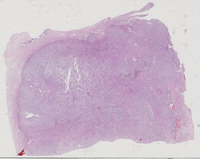

In [36]:
# quick plotting util
slide.get_thumbnail((200, 200))

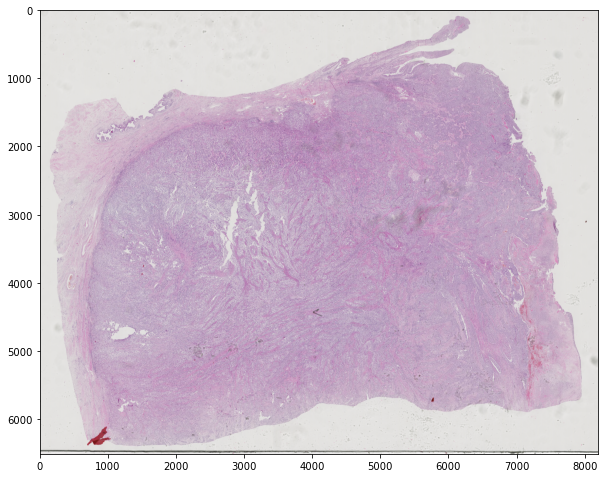

In [39]:
import matplotlib.pyplot as plt
from typing import *

def plot_slide(slide: OpenSlide, start_region: Tuple=(0, 0), level: int = 0, size: Tuple = None)  -> None:
    """

    Args:
        slide (OpenSlide): openslide object
        start_region (Tuple): top left pixel of the region to plot (use for sliding windows/patches)
        level (int): resolution, where level=0 is highest resolution (view slide.properties for resolution details)
        size ():

    Returns:

    """
    size = slide.level_dimensions[level]
    region = slide.read_region(start_region, level, size)
    plt.figure(figsize=(10, 10))
    plt.imshow(region)

plot_slide(slide, level=2) # note: level 0 and 1 take a while to load/display

In [60]:
def load_slide_tensors(slide: OpenSlide, level: int = None):
region = slide.read_region((0,0), level=3, size=slide.level_dimensions[3])
region_arr = np.array(region)
region_tensor = transforms.ToTensor()(region)

In [57]:
region.mode

'RGBA'

### Sanity checks

In [90]:
from x_perceiver.utils import Config
from x_perceiver.etl import TCGADataset
config = Config("config/main.yml").read()
brca = TCGADataset("brca", config)
blca = TCGADataset("blca", config)